# Imports and paths

In [1]:
# ROOT PATH
# REPLACE root_path WITH CORRECT ROOT FOLDER PATH
root_path = "C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/"

# path to code base
code_base_path = root_path + "Code/datafi_palindrome_segmentation/"
# path to root of raw data files
raw_data_path = root_path + "Data/"
# path to output folder
output_data_path = root_path + "Output Data - SA/"

In [2]:
### Import standard libraries
import os
# change working directory to the code base folder
os.chdir(path=code_base_path)

import pandas as pd
import geopandas as gpd

# Data variable selection and merging

## Import raw survey datasets

In [3]:
### DHS
# Women ("Individuals" dataset)
dhs_w_raw = pd.read_stata(raw_data_path + "DHS/SA/ZAIR71DT/ZAIR71FL.DTA")
# Men
dhs_m_raw = pd.read_stata(raw_data_path + "DHS/SA/ZAMR71DT/ZAMR71FL.DTA")

### AHS
# Women
ahs_w_raw = pd.read_stata(raw_data_path + "DHS/SA/ZAAH71DT/ZAAHW71FL.DTA")
# Men
ahs_m_raw = pd.read_stata(raw_data_path + "DHS/SA/ZAAH71DT/ZAAHM71FL.DTA")

### HIV tests
hiv_raw = pd.read_stata(raw_data_path + "DHS/SA/ZAAR71DT/ZAAR71FL.DTA")

### Geographic (GPS coordinates for each household cluster)
cluster_gps_gdf = gpd.read_file(raw_data_path + "DHS/SA/ZAGE71FL/ZAGE71FL.dbf")

## Import processed variable lists

In [4]:
# Import variable info dataframe
all_vars = pd.read_excel(output_data_path + "Variables/usable_variables_info.xlsx", sheet_name="All")

In [5]:
# Extract relevant variable lists

# DHS
dhs_vars_df = all_vars.query("source_dhs == 1")
dhs_w_vars_list = dhs_vars_df.loc[dhs_vars_df["variable_women"].notnull(), "variable_women"]
dhs_m_vars_list = dhs_vars_df.loc[dhs_vars_df["variable_men"].notnull(), "variable_men"]

# AHS
ahs_vars_df = all_vars.query("source_ahs == 1")
ahs_w_vars_list = ahs_vars_df.loc[ahs_vars_df["variable_women"].notnull(), "variable_women"]
ahs_m_vars_list = ahs_vars_df.loc[ahs_vars_df["variable_men"].notnull(), "variable_men"]

# HIV dataset: men and women var are the same here.
hiv_vars_list = all_vars.query("source_hiv == 1")["variable_women"]

### Select chosen variables from raw datasets and relabel men's variables where possible

#### DHS

In [6]:
# Women
dhs_w = dhs_w_raw[dhs_w_vars_list].copy()
# Men
dhs_m = dhs_m_raw[dhs_m_vars_list].copy()


## rename men's variable names with women's when both are available
# get mapping
dhs_common = dhs_vars_df.dropna(subset=["variable_men", "variable_women"])
dhs_men_to_women_var_rename_dict = dict(zip(dhs_common["variable_men"], dhs_common["variable_women"]))
# apply
dhs_m = dhs_m.rename(dhs_men_to_women_var_rename_dict, axis=1)

#### AHS

In [7]:
# Women
ahs_w = ahs_w_raw[ahs_w_vars_list].copy()
# Men
ahs_m = ahs_m_raw[ahs_m_vars_list].copy()

# Relabel the AHS sample weight variable to not confuse with DHS sample weights
ahs_w = ahs_w.replace({"mv005": "mv005_ahs"})
ahs_m = ahs_m.replace({"mv005": "mv005_ahs"})

## rename men's variable names with women's when both are available
# get mapping
ahs_common = ahs_vars_df.dropna(subset=["variable_men", "variable_women"])
ahs_men_to_women_var_rename_dict = dict(zip(ahs_common["variable_men"], ahs_common["variable_women"]))
# apply
ahs_m = ahs_m.rename(ahs_men_to_women_var_rename_dict, axis=1)

#### HIV

In [8]:
hiv = hiv_raw[hiv_vars_list].copy()


## Merge datasets

### Prep

In [9]:
# add gender columns
# DHS
dhs_w = dhs_w.assign(gender="woman")
dhs_m = dhs_m.assign(gender="man")
# AHS
ahs_w = ahs_w.assign(gender="woman")
ahs_m = ahs_m.assign(gender="man")

# combine men and women datasets
dhs = pd.concat([dhs_w, dhs_m])
ahs = pd.concat([ahs_w, ahs_m])

# Add columns to signify data sources available for that row
dhs = dhs.assign(source_dhs=1)
ahs = ahs.assign(source_ahs=1)
hiv = hiv.assign(source_hiv=1)

# rename cluster, household, and line numbers
# DHS
dhs.rename(columns={"v001": "cluster", "v002": "household", "v003": "line"}, inplace=True)
# AHS
ahs.rename(columns={"v001": "cluster", "v002": "household", "v003": "line"}, inplace=True)
# HIV
hiv.rename(columns={"hivclust": "cluster", "hivnumb": "household", "hivline": "line"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


### Merge DHS, AHS, and HIV datasets

In [10]:
### combine DHS and AHS datasets
# "outer" join keeps all rows from both datasets

## ORIGINAL:
# AHS information is not injected into DHS variables (in the instance where the variable comes up in both surveys);
# only new AHS variables are added
new_cols_in_ahs = ahs.columns.difference(dhs.columns).tolist()
df = pd.merge(
    dhs,
    ahs[["cluster", "household", "line"] + new_cols_in_ahs],
    on=["cluster", "household", "line"],
    how="outer",
)
# # NEW:
# # AHS information is added to DHS where possible as well as new AHS variables added
# df = pd.merge(dhs, ahs, how='outer') # joins on intersection of columns

# add on HIV dataset
df = pd.merge(df, hiv, on=["cluster", "household", "line"], how="outer")

## Add geographical columns for spatial groupings
Requires external shapefiles for country admin level 2.

<AxesSubplot:>

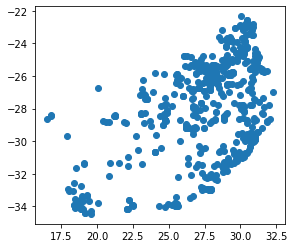

In [11]:
cluster_gps_gdf.plot()

In [12]:
# Select useful columns from this dataframe
# cluster_gps.columns.tolist()

cluster_cols = [
    #'DHSID', 'DHSCC', 'DHSYEAR',                           # = ZA201700000001 to 750, ZA, 2017
    "DHSCLUST",
    # 'CCFIPS',                                             # = SF
    #'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO',  # = NaN
    "ADM1DHS",
    "ADM1NAME",
    #'DHSREGCO', 'DHSREGNA',                                # Repeats
    #'SOURCE',                                              # = GPS
    "URBAN_RURA",
    "LATNUM",
    "LONGNUM",
    #'ALT_GPS', 'ALT_DEM', 'DATUM'                          # 9999, (ALT_DEM?), WGS84
]

### Import shapefiles for districts

Link: https://data.humdata.org/dataset/cod-ab-zaf

File: zaf_adm_sadb_ocha_20201109_SHP.zipSHP (87.8M)

Extract to folder of same name.

<AxesSubplot:>

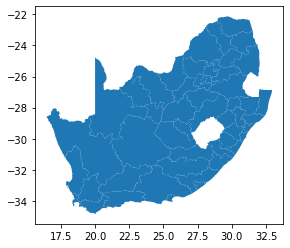

In [13]:
district_shapes_path = (
    # root
    raw_data_path
    # extracted folder
    + "UNOCHA Subnational Administrative Boundaries/zaf_adm_sadb_ocha_20201109_shp/"
    # file: change following file to zaf_admbnda_adm1_sadb_ocha_20201109.dbf for level-1 admin area shapes (region)
    + "zaf_admbnda_adm2_sadb_ocha_20201109.dbf"
)

district_shapes = gpd.read_file(district_shapes_path)
district_shapes.plot()

In [14]:
# Select useful columns from this dataframe
# district_shapes.columns.tolist()

district_cols = [

    # District
    "ADM2_ID",
    "ADM2_EN",
    "ADM2_PCODE",
    # 'ADM2_REF',
    # 'ADM2ALT1EN',
    # 'ADM2ALT2EN',

    # Region
    "ADM1_ID",
    "ADM1_EN",
    "ADM1_PCODE",

    # # Country
    # "ADM0_EN",
    # "ADM0_PCODE",

    # # Date information    # Based on data from 2016.
    # "date",               # 2018-12-27
    # "validOn",            # 2020-11-09
    # "validTo",            # NaN

    # # Geographic
    # 'Shape_Leng',
    # 'Shape_Area',
    # 'geometry'
]

### Find out which district (admin level 2) each cluster is within

NOTE: Grouping only valid to level-2 adminstrative area, District, no lower. 

See "GPS_Displacement_README.txt" documentation in DHS data folder for Geographic data, ZAGE71FL.

In [15]:
# ensure they are using the same projection
district_shapes.crs = cluster_gps_gdf.crs
# join dataframes
enhanced_gps_gdf = gpd.sjoin(district_shapes, cluster_gps_gdf, how="right")

In [16]:
# convert to regular dataframe
enhanced_gps_df = pd.DataFrame(enhanced_gps_gdf)

# discard unwanted columns
gps_cols_to_keep = cluster_cols + district_cols
enhanced_gps_df = enhanced_gps_df[gps_cols_to_keep]

# convert cluster and region numbers to integers from floats
enhanced_gps_df["DHSCLUST"] = enhanced_gps_df["DHSCLUST"].astype("int")
enhanced_gps_df["ADM1DHS"] = enhanced_gps_df["ADM1DHS"].astype("int")

# rename cluster column to prepare for merging into main DHS dataframe
enhanced_gps_df.rename(columns={"DHSCLUST": "cluster"}, inplace=True)

# enhanced_gps_df.head()

### Finally, add geographical variables to the merged survey dataset

In [17]:
df = df.merge(enhanced_gps_df)

# Save resulting dataset to file

In [18]:
print("Observations with DHS data:", df.query("source_dhs == 1").shape[0])
print("Observations with AHS data:", df.query("source_ahs == 1").shape[0])
print(
    "Observations with DHS and AHS data:",
    df.query("source_dhs == 1 and source_ahs == 1").shape[0],
)
print(
    "Observations with DHS and AHS and HIV data:",
    df.query("source_dhs == 1 and source_ahs == 1 and source_hiv == 1").shape[0],
)

## OLD (check against these values)
# Observations with DHS data: 12132
# Observations with AHS data: 10336
# Observations with DHS and AHS data: 7811
# Observations with DHS and AHS and HIV data: 4862


Observations with DHS data: 12132
Observations with AHS data: 10336
Observations with DHS and AHS data: 7811
Observations with DHS and AHS and HIV data: 4862


In [19]:
# save merged dataframe to file
df.to_csv(output_data_path + "Processed Data/DHS_merged.csv", index=False)